In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import scipy as sp
from typing import List
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

src_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src'
if not src_dir in sys.path: sys.path.append(src_dir)
utils_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src/utils'
if not utils_dir in sys.path: sys.path.append(utils_dir)
from constants import *
from CosmoFunc import *

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

from matplotlib.ticker import FormatStrFormatter

from step_7_fit_fp import fit_FP
from step_8_fit_logdist import fit_logdist

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
FP_SETTING = int(os.environ.get('FP_SETTING'))

# 1. 6dFGS

### Plot count and logdist vs richness

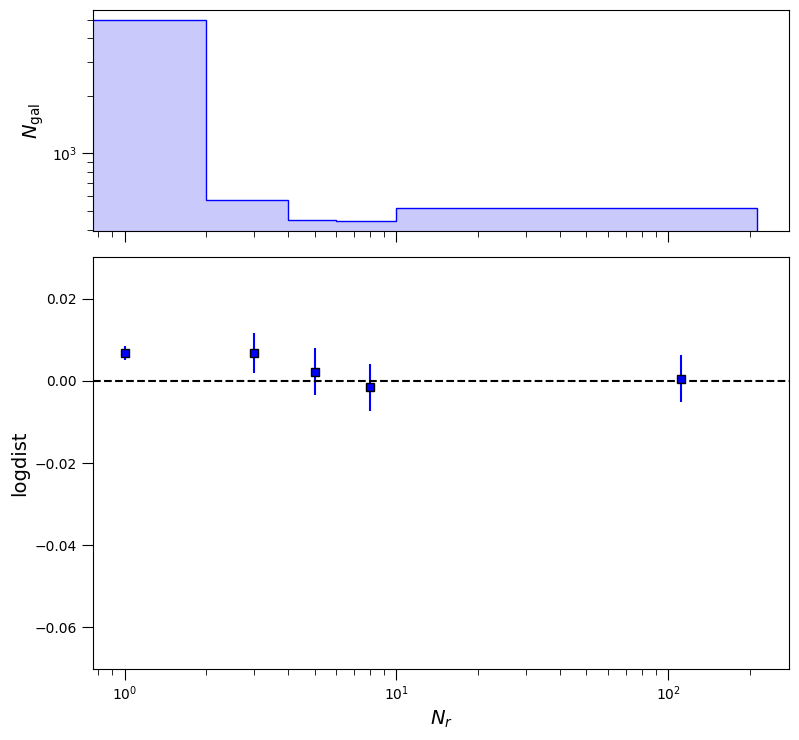

In [217]:
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/completeness_setting_1/fp_setting_0/6dfgs.csv')
# df = df[df['Nr'] > 0]

# Divide into richness classes (10% quantile)
qcut_, qcut_bins = pd.qcut(x=df['Nr'], q=15, duplicates='drop', retbins=True)
df['richness_class'] = pd.cut(df['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='richness_class', observed=False).agg(
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist_mean_cf', 'mean'),
    logdist_rms=('logdist_mean_cf', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)


fig.tight_layout()

In [219]:
req_cols = ['_2MASX', 'Jlogr', 'n', 'Hlogr', 'Klogr', '_6dFGS', 'RAJ2000', 
            'DEJ2000', 'cz', 'Mt', 'Group', 'Nr', 'Ng', 'cz_gr']
with fits.open('../data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()[req_cols]

In [223]:
df_fp[df_fp['Nr'] < df_fp['Ng']]

,_2MASX,Jlogr,n,Hlogr,Klogr,_6dFGS,RAJ2000,DEJ2000,cz,Mt,Group,Nr,Ng,cz_gr
25,J00024429-5344549,0.699,6.00,0.703,0.738,g0002443-534455,0.04563,-53.74858,10287,3.7,826,3,5,10825
27,J00030547-5402112,0.239,6.00,0.323,0.320,g0003055-540211,0.05153,-54.03642,10678,0.2,826,3,5,10825
44,J00050967-5358015,0.483,6.00,0.695,0.535,g0005096-535801,0.08601,-53.96706,10948,2.2,826,3,5,10825
49,J00053994-5349010,0.909,6.00,0.918,0.771,g0005400-534901,0.09443,-53.81692,10857,1.5,826,3,5,10825
58,J00062878-5349382,0.518,6.00,0.412,0.481,g0006288-534938,0.10800,-53.82730,10828,0.8,826,3,5,10825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,J23525776-0243335,0.730,2.94,0.751,0.671,g2352578-024333,23.88271,-2.72594,6415,2.5,362,0,2,6490
11057,J23540640-0231488,0.463,4.18,0.434,0.486,g2354064-023149,23.90178,-2.53019,6506,2.0,362,0,2,6490
11073,J23555973-0134102,0.180,4.57,0.177,0.290,g2355597-013410,23.93326,-1.56947,10582,0.0,891,1,3,11112
11074,J23560060-0140412,0.365,4.49,0.361,0.374,g2356006-014042,23.93350,-1.67819,11242,3.0,891,1,3,11112


In [235]:
df = pd.read_csv('../data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)
# df[['Groupid', 'Nr']]
df[df['2MASSid'] == '2MASXJ23525776-0243335']

,6dFGSid,2MASSid,ra,dec,cz,logRe_J,elogRe_J,logRe_H,elogRe_H,logRe_K,...,Nr,zgroup,dist5,sdens5,sampcodeJ,pvcodeJ,sampcodeH,pvcodeH,sampcodeK,pvcodeK
11050,g2352578-024333,2MASXJ23525776-0243335,23.88271,-2.72594,6415,0.216,0.041,0.237,0.048,0.157,...,0,6490,2.7475,0.213,111111,1,111111,1,111111,1


In [240]:
# df[df['Nr']==1][['Groupid', 'Nr']]
df[df['Groupid']==891]

,6dFGSid,2MASSid,ra,dec,cz,logRe_J,elogRe_J,logRe_H,elogRe_H,logRe_K,...,Nr,zgroup,dist5,sdens5,sampcodeJ,pvcodeJ,sampcodeH,pvcodeH,sampcodeK,pvcodeK
11073,g2355597-013410,2MASXJ23555973-0134102,23.93326,-1.56947,10582,-0.108,0.064,-0.111,0.077,0.002,...,1,11112,4.9063,0.0703,111111,1,111011,0,111111,1
11074,g2356006-014042,2MASXJ23560060-0140412,23.93350,-1.67819,11242,0.077,0.060,0.073,0.072,0.086,...,1,11112,5.1366,0.0628,111111,1,111111,1,111111,1
11082,g2356462-013500,2MASXJ23564613-0134599,23.94615,-1.58342,11512,0.215,0.048,0.222,0.057,0.216,...,1,11112,5.9857,0.0453,111111,1,111111,1,111111,1


In [241]:
df_fp[df_fp['Group']==891]

,_2MASX,Jlogr,n,Hlogr,Klogr,_6dFGS,RAJ2000,DEJ2000,cz,Mt,Group,Nr,Ng,cz_gr
11073,J23555973-0134102,0.180,4.57,0.177,0.290,g2355597-013410,23.93326,-1.56947,10582,0.0,891,1,3,11112
11074,J23560060-0140412,0.365,4.49,0.361,0.374,g2356006-014042,23.93350,-1.67819,11242,3.0,891,1,3,11112
11082,J23564613-0134599,0.503,5.69,0.510,0.504,g2356462-013500,23.94615,-1.58342,11512,0.0,891,1,3,11112


### Categorize galaxies based on richness

In [200]:
# Use the same bin edges as Cullan
richness_bin = [1, 2, 4, 8, 16, 30, 60]

# 2. SDSS

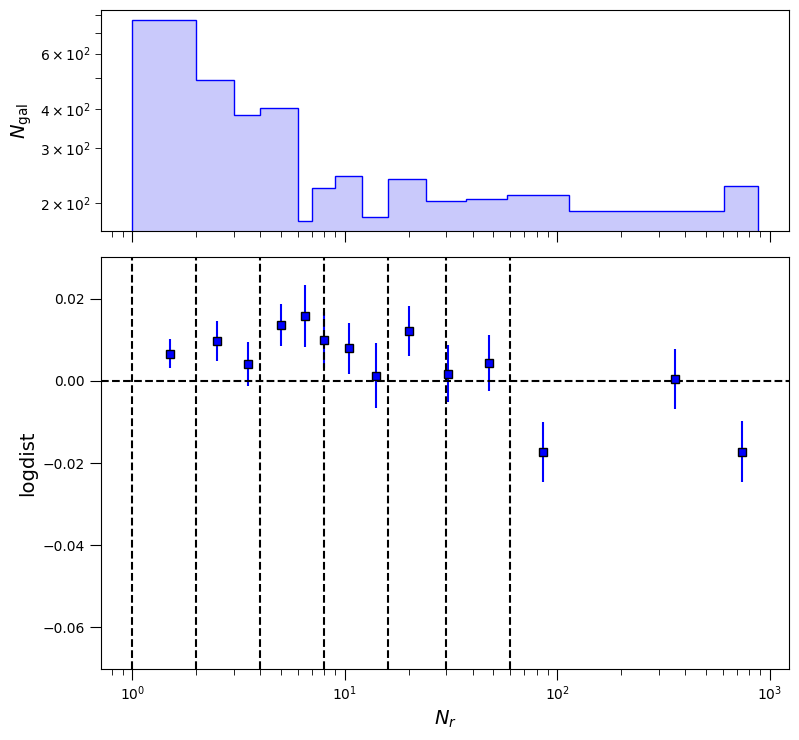

In [2]:
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/completeness_setting_1/fp_setting_0/sdss.csv')

# Divide into richness classes (10% quantile)
qcut_, qcut_bins = pd.qcut(x=df['Nr'], q=20, duplicates='drop', retbins=True)
df['richness_class'] = pd.cut(df['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='richness_class', observed=False).agg(
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist_mean_cf', 'mean'),
    logdist_rms=('logdist_mean_cf', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)

# Use the same bin edges as Cullan
richness_bin = [1, 2, 4, 8, 16, 30, 60]
for x_ in richness_bin:
    ax2.axvline(x=x_, ls='--', c='k')

fig.tight_layout()

### Fit the FP based on richness

In [3]:
survey = 'SDSS'

# Load the post-logdist fit data
df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_1/fp_setting_0/{survey.lower()}.csv')

# Use the same bin edges as Cullan
richness_bins = [1, 2, 4, 8, 16, 30, 60, np.inf]
richness_labels = list(range(1, len(richness_bins)))
df['Nr_bin'] = pd.cut(df['Nr'], bins=richness_bins, labels=richness_labels, right=False)

# Fit the FP for each survey
FP_params = []
for bin_label in richness_labels:
    # Select the richness class
    df_bin = df[df['Nr_bin'] == bin_label]

    # Get completeness setting
    use_completeness_model = True
    completeness_model_filepath = os.path.join(ROOT_PATH, 'artifacts/fp_fit/smin_setting_1/completeness.csv') if use_completeness_model else None

    # Get output filepath
    output_filepath = os.path.join(ROOT_PATH, f'scrap/richness_experiment/fp_sample_final/bin_{bin_label}/sdss.csv')
    create_parent_folder(output_filepath)
    
    # Velocity dispersion lower limit
    if survey == 'ALL_COMBINED':
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING]['6dFGS']
    else:
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

    params = fit_FP(
        survey=survey,
        df=df_bin,
        outlier_output_filepath=output_filepath,
        smin=smin,
        use_completeness_model=use_completeness_model,
        completeness_model_filepath=completeness_model_filepath
    )
    params = np.append(params, np.array([len(df_bin)]))
    FP_params.append(params)

# Convert the FP parameters to dataframe and save to artifacts folder
FP_params = np.array(FP_params)
FP_columns = ['a', 'b', 'rmean', 'smean', 'imean', 's1', 's2', 's3', 'Ngal']
df_fp = pd.DataFrame(FP_params, columns=FP_columns, index=richness_labels)
df_fp['Ngal'] = df_fp['Ngal'].astype(int)
df_fp.index.names = ['bin']
df_fp.to_csv('../scrap/richness_experiment/fp_fits.csv')

### Fit the logdist based on the previous fits

In [7]:
survey = 'SDSS'

# Use the same bin edges as Cullan
richness_labels = list(range(1, len(richness_bins)))

df_full = pd.DataFrame()
# Load each bin
for bin_label in richness_labels:
    # Load data
    df = pd.read_csv(f'../scrap/richness_experiment/fp_sample_final/bin_{bin_label}/{survey.lower()}.csv')
    
    # Rename logdist column
    df['logdist'] = df['logdist_mean_cf']
    
    # Load smin
    smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]
    
    # Get the FP parameters to be used for fitting
    FPparams = pd.read_csv('../scrap/richness_experiment/fp_fits.csv', index_col=0).loc[bin_label].to_numpy()[:-1]
    
    df = fit_logdist(
        survey=survey,
        df=df,
        smin=smin,
        FPparams=FPparams,
        save_posterior=False
            )
    
    # Rename logdist column (after richness correction)
    df['logdist_corr'] = df['logdist_mean_cf']
    
    # Save the output
#     df.to_csv(os.path.join(ROOT_PATH, f'scrap/richness_experiment/logdist/bin_{bin_label}/{survey.lower()}.csv'))
    df_full = pd.concat([df_full, df])

### Create logdist vs richness plot again

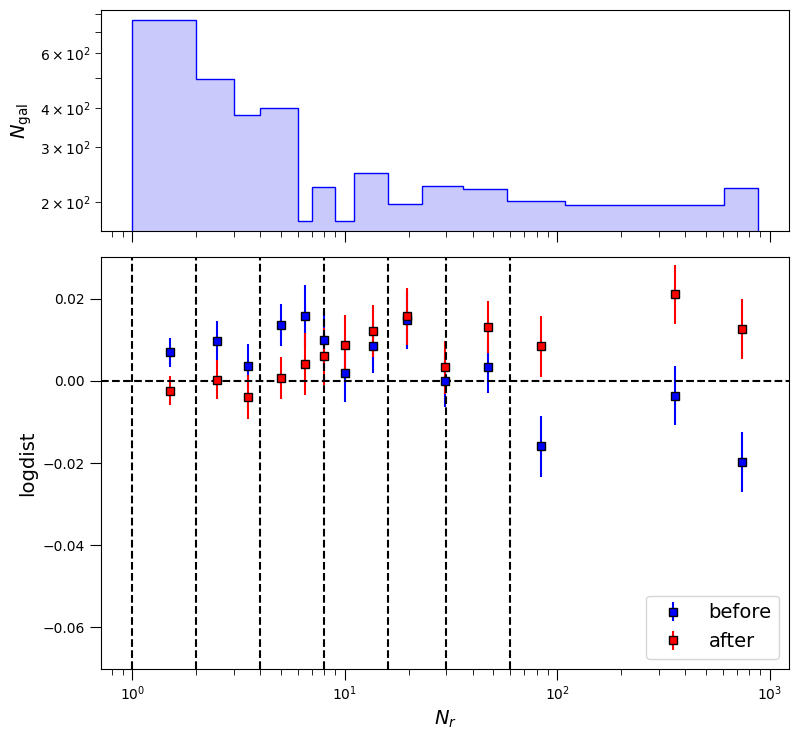

In [33]:
df = df_full

# Divide into richness classes (10% quantile)
qcut_, qcut_bins = pd.qcut(x=df['Nr'], q=20, duplicates='drop', retbins=True)
df['richness_class'] = pd.cut(df['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='richness_class', observed=False).agg(
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist', 'mean'),
    logdist_rms=('logdist', 'std'),
    logdist_corr_mean=('logdist_corr', 'mean'),
    logdist_corr_rms=('logdist_corr', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])
df_grouped['logdist_corr_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_corr_mean'], yerr=df_grouped['logdist_corr_mean_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)
ax2.legend(fontsize=14)

# Use the same bin edges as Cullan
richness_bin = [1, 2, 4, 8, 16, 30, 60]
for x_ in richness_bin:
    ax2.axvline(x=x_, ls='--', c='k')

fig.tight_layout()

### Plot corrected logdist vs redshift

(-0.2, 0.2)

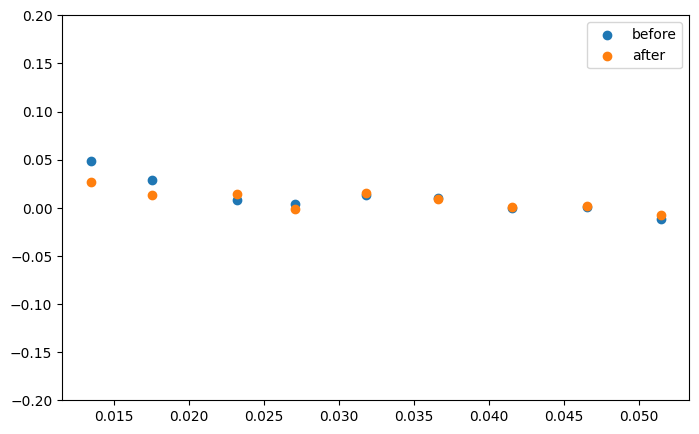

In [35]:
df = df_full

# Divide into redshift bins
z_bins = bin_list = np.linspace(df['z_dist_est'].min(), df['z_dist_est'].max(), 10)
z_bin_labels = list(range(1, len(z_bins)))
df['z_bin'] = pd.cut(df['z_dist_est'], z_bins, labels=z_bin_labels)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='z_bin', observed=False).agg(
    z_bin_count=('z_bin', 'count'),
    z_mean=('z_dist_est', 'mean'),
    logdist_median=('logdist', 'median'),
    logdist_rms=('logdist', 'std'),
    logdist_corr_median=('logdist_corr', 'median'),
    logdist_corr_rms=('logdist_corr', 'std')
)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

ax.scatter(df_grouped['z_mean'], df_grouped['logdist_median'], label='before')
ax.scatter(df_grouped['z_mean'], df_grouped['logdist_corr_median'], label='after')
ax.legend()

ax.set_ylim(-0.2, 0.2)

In [28]:
df_grouped

,z_bin_count,z_mean,logdist_median,logdist_rms,logdist_corr_median,logdist_corr_rms
z_bin,,,,,,
1,8,0.011945,-0.094577,0.072853,-0.098050,0.069231
2,39,0.014917,0.033934,0.085974,0.018242,0.093505
3,63,0.017775,0.036054,0.106012,0.023788,0.105175
4,125,0.021298,0.008529,0.108765,-0.006335,0.112006
5,454,0.024067,0.011013,0.101505,0.014489,0.099675
6,256,0.027380,0.006454,0.101127,0.001923,0.098479
7,464,0.030478,0.007604,0.102076,0.003728,0.099768
8,406,0.033611,0.016825,0.096475,0.015541,0.095173
9,467,0.036629,0.009876,0.099409,0.012099,0.098583


In [20]:
z_bins

array([0.01003, 0.06003])

# 3. LAMOST

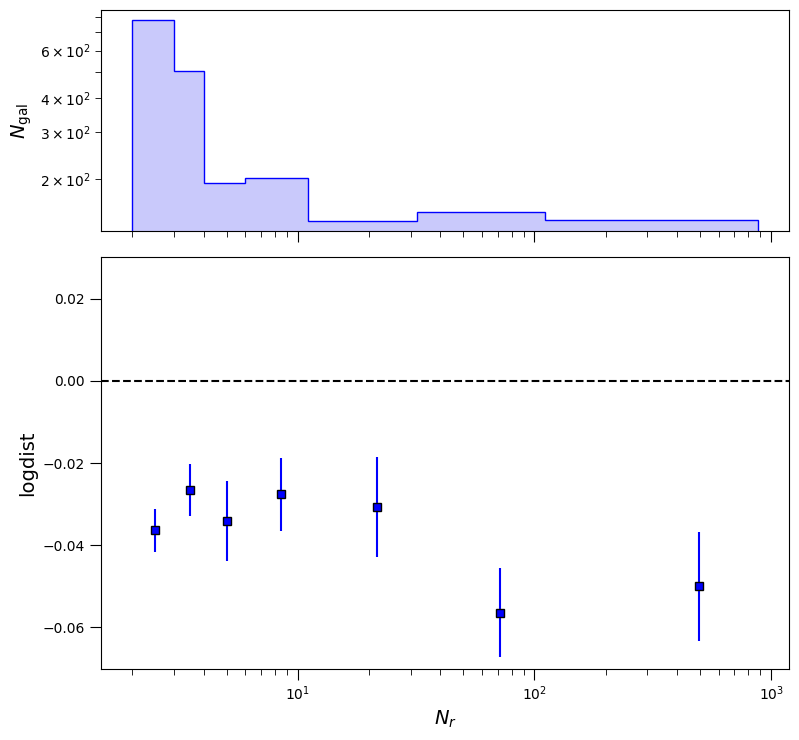

In [249]:
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/completeness_setting_1/fp_setting_0/lamost.csv')
# df = df[df['Nr'] > 0]

# Divide into richness classes (10% quantile)
qcut_, qcut_bins = pd.qcut(x=df['Nr'], q=15, duplicates='drop', retbins=True)
df['richness_class'] = pd.cut(df['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='richness_class', observed=False).agg(
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist_mean_cf', 'mean'),
    logdist_rms=('logdist_mean_cf', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)


fig.tight_layout()

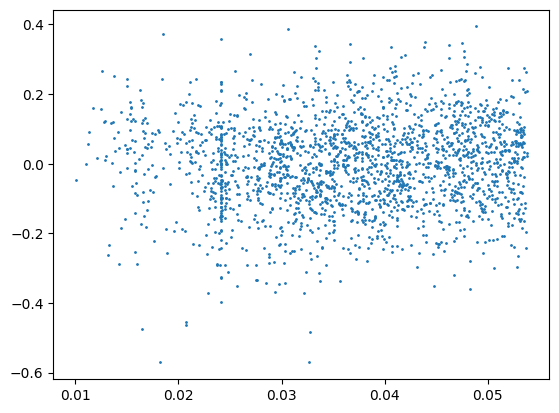

In [177]:
plt.scatter(df['z_dist_est'], df['logdist_mean_cf'], s=1)